In [1]:
import pandas as pd
import numpy as np
from pathlib import Path


In [3]:
def import_csv(filename: str) -> pd.DataFrame:
    csv_path = Path("Data") / filename
    return pd.read_csv(str(csv_path))

data_config = {
    "account_activity": "Customer Profiles/account_activity.csv",
    "customer_data": "Customer Profiles/customer_data.csv",
    "fraud_indicators": "Fraudulent Patterns/fraud_indicators.csv",
    "suspicious_activity": "Fraudulent Patterns/suspicious_activity.csv",
    "merchant_data": "Merchant Information/merchant_data.csv",
    "transaction_category_labels": "Merchant Information/transaction_category_labels.csv",
    "amount_data": "Transaction Amounts/amount_data.csv",
    "anomaly_scores": "Transaction Amounts/anomaly_scores.csv",
    "transaction_metadata": "Transaction Data/transaction_metadata.csv",
    "transaction_records": "Transaction Data/transaction_records.csv",
}

# Preload all datasets into a dictionary
datasets = {name: import_csv(path) for name, path in data_config.items()}


In [4]:
# Dict mit Dateinamen und Spaltennamen erstellen
feature_names_by_file = {file_name: df.columns.tolist() for file_name, df in datasets.items()}

# Längsten key finden
max_key_length = max(len(file_name) for file_name in feature_names_by_file.keys())

# Über Dateinamen und Spalten iterieren
for file_name, columns in feature_names_by_file.items():
    # Verwenden der ljust, um den Dateinamen in einem Feld der Breite 'max_key_length' auszurichten
    formatted_file_name = file_name.ljust(max_key_length)
    print(f"{formatted_file_name}: {', '.join(columns)}")


account_activity           : CustomerID, AccountBalance, LastLogin
customer_data              : CustomerID, Name, Age, Address
fraud_indicators           : TransactionID, FraudIndicator
suspicious_activity        : CustomerID, SuspiciousFlag
merchant_data              : MerchantID, MerchantName, Location
transaction_category_labels: TransactionID, Category
amount_data                : TransactionID, TransactionAmount
anomaly_scores             : TransactionID, AnomalyScore
transaction_metadata       : TransactionID, Timestamp, MerchantID
transaction_records        : TransactionID, Amount, CustomerID


In [25]:
import pandas as pd

# Annahme: Die Datasets wurden bereits geladen und sind als Pandas DataFrames verfügbar
# Beispiel: customer_data = datasets['customer_data'], etc.

# Verknüpfen von Kundendaten
customer_info = pd.merge(datasets['customer_data'], datasets['account_activity'], on='CustomerID', how='left')
customer_info = pd.merge(customer_info, datasets['suspicious_activity'], on='CustomerID', how='left')

# Verknüpfen von Transaktionsdaten
transaction_info = pd.merge(datasets['transaction_metadata'], datasets['fraud_indicators'], on='TransactionID', how='left')
transaction_info = pd.merge(transaction_info, datasets['transaction_category_labels'], on='TransactionID', how='left')
transaction_info = pd.merge(transaction_info, datasets['amount_data'], on='TransactionID', how='left')
transaction_info = pd.merge(transaction_info, datasets['anomaly_scores'], on='TransactionID', how='left')

# Integration von Händlerdaten
transaction_info = pd.merge(transaction_info, datasets['merchant_data'], on='MerchantID', how='left')

# Verknüpfen von Kundendaten und Transaktionsdaten
# Da `transaction_records` sowohl `CustomerID` als auch `TransactionID` enthält, kann es als Brücke dienen
df = pd.merge(transaction_info, datasets['transaction_records'], on='TransactionID', how='left')
df = pd.merge(df, customer_info, on='CustomerID', how='left')
# Konvertierung des Timestamps
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# Überprüfung der resultierenden Tabelle
df.head()


,TransactionID,Timestamp,MerchantID,FraudIndicator,Category,TransactionAmount,AnomalyScore,MerchantName,Location,Amount,CustomerID,Name,Age,Address,AccountBalance,LastLogin,SuspiciousFlag
0,1,2022-01-01 00:00:00,2701,0,Other,79.413607,0.686699,Merchant 2701,Location 2701,55.530334,1952,Customer 1952,50,Address 1952,2869.689912,2024-08-09,0
1,2,2022-01-01 01:00:00,2070,0,Online,12.053087,0.081749,Merchant 2070,Location 2070,12.881180,1027,Customer 1027,46,Address 1027,9527.947107,2022-01-27,0
2,3,2022-01-01 02:00:00,2238,0,Travel,33.310357,0.023857,Merchant 2238,Location 2238,50.176322,1955,Customer 1955,34,Address 1955,9288.355525,2024-08-12,0
3,4,2022-01-01 03:00:00,2879,0,Travel,46.121117,0.876994,Merchant 2879,Location 2879,41.634001,1796,Customer 1796,33,Address 1796,5588.049942,2024-03-06,0
4,5,2022-01-01 04:00:00,2966,0,Other,54.051618,0.034059,Merchant 2966,Location 2966,78.122853,1946,Customer 1946,18,Address 1946,7324.785332,2024-08-03,0


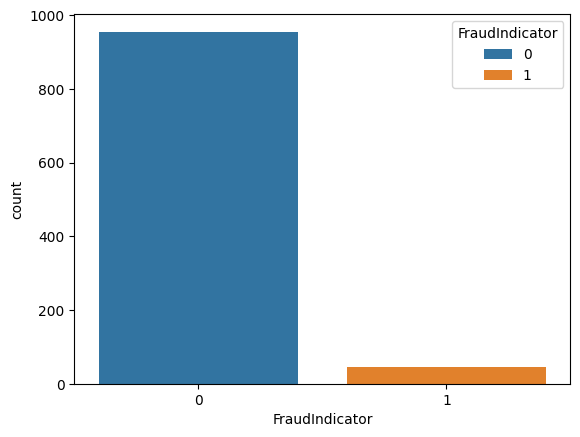

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotten der binären Zielvariable FraudIndicator
sns.countplot(x='FraudIndicator', data=df, hue='FraudIndicator')

plt.show()


In [24]:
sum(df["FraudIndicator"])

45

In [9]:
import networkx as nx
import plotly.graph_objs as go
import pandas as pd

# Angenommen, 'final_table' ist dein kombinierter DataFrame und bereits geladen

# Erstelle den Graphen
G = nx.Graph()

# Knoten für Kunden, Transaktionen und Händler hinzufügen
for index, row in df.iterrows():
    G.add_node(f"C{row['CustomerID']}", type='Customer', fraud=row['FraudIndicator'] == 1)
    G.add_node(f"T{row['TransactionID']}", type='Transaction')
    G.add_node(f"M{row['MerchantID']}", type='Merchant')

    # Kanten hinzufügen
    G.add_edge(f"C{row['CustomerID']}", f"T{row['TransactionID']}")
    G.add_edge(f"T{row['TransactionID']}", f"M{row['MerchantID']}")

# Berechnen der Positionen für jeden Knoten in 3D
pos = nx.spring_layout(G, dim=3)

# Extrahiere die x, y, z Positionen in separate Listen
x_nodes = [pos[node][0] for node in G.nodes()]  # x Positionen
y_nodes = [pos[node][1] for node in G.nodes()]  # y Positionen
z_nodes = [pos[node][2] for node in G.nodes()]  # z Positionen

# Knotenfarben basierend auf dem Betrugsindikator
node_color = ['red' if G.nodes[node]['type'] == 'Customer' and G.nodes[node]['fraud'] else 'blue' for node in G.nodes()]

# Erstelle die 3D-Plotly Graphen-Daten
trace_nodes = go.Scatter3d(x=x_nodes, y=y_nodes, z=z_nodes, mode='markers', marker=dict(size=6, color=node_color))

# Kanten für den Plotly Graphen vorbereiten
edge_x = []
edge_y = []
edge_z = []
for edge in G.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_z.extend([z0, z1, None])

trace_edges = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', line=dict(color='black', width=1))

# Definiere das Layout für die 3D-Visualisierung
layout = go.Layout(title="Netzwerk von Kunden, Transaktionen und Händlern", showlegend=False)

# Kombiniere die Knoten- und Kanten-Daten für den Plot
fig = go.Figure(data=[trace_edges, trace_nodes], layout=layout)

# Zeige den Plot an
fig.show()
